# Applied Finance Project - EUR/PLN Strategy

#### Rajat Dogra, Student ID - 474072

- Optimized parameters: k=1, signal_span=30, slower_span=90, sd_span=90
- Strategy type: Momentum (MOM)
- Backtest period: 01.09.2025 – 06.10.2025
- Out-of-sample: 22.09.2025 – 06.10.20254

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Load the data

Downloaded from https://www.histdata.com/

In [2]:
# Load EUR/PLN minute data
sep_data = pd.read_csv('HISTDATA_COM_MT_EURPLN_M1202509/DAT_MT_EURPLN_M1_202509.csv',
                       names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
oct_data = pd.read_csv('HISTDATA_COM_MT_EURPLN_M1202510/DAT_MT_EURPLN_M1_202510.csv',
                       names=['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume'])

data = pd.concat([sep_data, oct_data], ignore_index=True)
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.set_index('DateTime', inplace=True)
data.sort_index(inplace=True)

# Filter to project period
start_date = pd.Timestamp('2025-09-01')
end_date = pd.Timestamp('2025-10-06 23:59:59')
data = data[(data.index >= start_date) & (data.index <= end_date)]
data = data[['Close']]

# ✅ Ensure Close is numeric and drop invalid rows
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
data = data.dropna(subset=['Close'])

print(f"Loaded {len(data)} data points from {data.index[0]} to {data.index[-1]}")
data.head()


Loaded 34824 data points from 2025-09-01 00:00:00 to 2025-10-06 23:59:00


,Close
DateTime,
2025-09-01 00:00:00,4.26269
2025-09-01 00:01:00,4.26269
2025-09-01 00:02:00,4.26259
2025-09-01 00:03:00,4.26171
2025-09-01 00:04:00,4.26274


## Split Train/Test

In [3]:
train_end = '2025-09-22 00:00:00'
train_data = data[data.index < train_end]
test_data = data[data.index >= train_end]

print(f"Training period: {len(train_data)} observations")
print(f"Test period: {len(test_data)} observations")


Training period: 20130 observations
Test period: 14694 observations


## Set Parameters

In [4]:
# Strategy parameters
k = 1
signal_span = 30
slower_span = 90
sd_span = 90
spread_cost = 0.00005  # realistic spread in EUR/PLN


## Backtest Function

In [5]:

def sharpe_ratio(pnl, scale):
    """Compute annualized Sharpe Ratio"""
    if len(pnl) == 0 or np.std(pnl) == 0:
        return 0
    return np.mean(pnl) / np.std(pnl) * np.sqrt(scale)

def backtest(prices, k=1, signal_span=30, slower_span=90, sd_span=90, spread_cost=0.00005):
    """
    Backtest momentum strategy using Bollinger-style bands.
    Returns a dictionary with performance metrics and series.
    """
    # Ensure prices are numeric
    prices = pd.to_numeric(prices, errors='coerce').dropna()
    
    # Compute returns
    returns = prices.pct_change().fillna(0)
    
    # Technical indicators
    signal = prices.ewm(span=signal_span).mean()
    slower_avg = prices.ewm(span=slower_span).mean()
    rolling_std = prices.rolling(window=sd_span).std()
    
    # Bollinger-style bands
    lower = slower_avg - k * rolling_std
    upper = slower_avg + k * rolling_std
    
    # Generate positions
    positions = np.zeros(len(prices))
    for i in range(1, len(prices)):
        if not (pd.isna(signal.iloc[i]) or pd.isna(lower.iloc[i]) or pd.isna(upper.iloc[i])):
            if signal.iloc[i] > upper.iloc[i]:
                positions[i] = -1  # Sell
            elif signal.iloc[i] < lower.iloc[i]:
                positions[i] = 1   # Buy
            else:
                positions[i] = positions[i-1]  # Hold
    
    pos_series = pd.Series(positions, index=prices.index)
    pos_lagged = pos_series.shift(1).fillna(0)
    
    # Gross and net P&L
    gross_pnl = pos_lagged * returns
    n_transactions = pos_series.diff().abs()
    net_pnl = gross_pnl - (n_transactions * spread_cost)
    
    # Metrics
    cumulative_returns = (1 + net_pnl).cumprod()
    max_dd = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    net_sr = sharpe_ratio(net_pnl, 252*24*60)  # minute-level scaling
    win_rate = (net_pnl > 0).sum() / (net_pnl != 0).sum() if (net_pnl != 0).sum() > 0 else 0
    
    return {
        'gross_pnl': gross_pnl.sum(),
        'net_pnl': net_pnl.sum(),
        'buy_hold': returns.sum(),
        'excess_return': net_pnl.sum() - returns.sum(),
        'net_sr': net_sr,
        'max_dd': max_dd,
        'win_rate': win_rate,
        'n_trades': n_transactions.sum(),
        'positions': pos_lagged,
        'net_pnl_series': net_pnl,
        'cumulative_returns': cumulative_returns
    }


## Run Backtest

In [6]:
# Ensure numeric Close values in train/test data
train_data['Close'] = pd.to_numeric(train_data['Close'], errors='coerce')
train_data = train_data.dropna(subset=['Close'])

test_data['Close'] = pd.to_numeric(test_data['Close'], errors='coerce')
test_data = test_data.dropna(subset=['Close'])

# === Backtest ===
# Train period
train_results = backtest(train_data['Close'])
print("=== Training Period ===")
for k, v in train_results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")

# Test period (out-of-sample)
test_results = backtest(test_data['Close'])
print("\n=== Out-of-Sample ===")
for k, v in test_results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")


=== Training Period ===
gross_pnl: 0.0064
net_pnl: 0.0046
buy_hold: 0.0003
excess_return: 0.0043
net_sr: 1.4645
max_dd: -0.0060
win_rate: 0.5014
n_trades: 35.0000

=== Out-of-Sample ===
gross_pnl: 0.0148
net_pnl: 0.0123
buy_hold: -0.0028
excess_return: 0.0151
net_sr: 6.2294
max_dd: -0.0034
win_rate: 0.5037
n_trades: 49.0000


## Plot Results

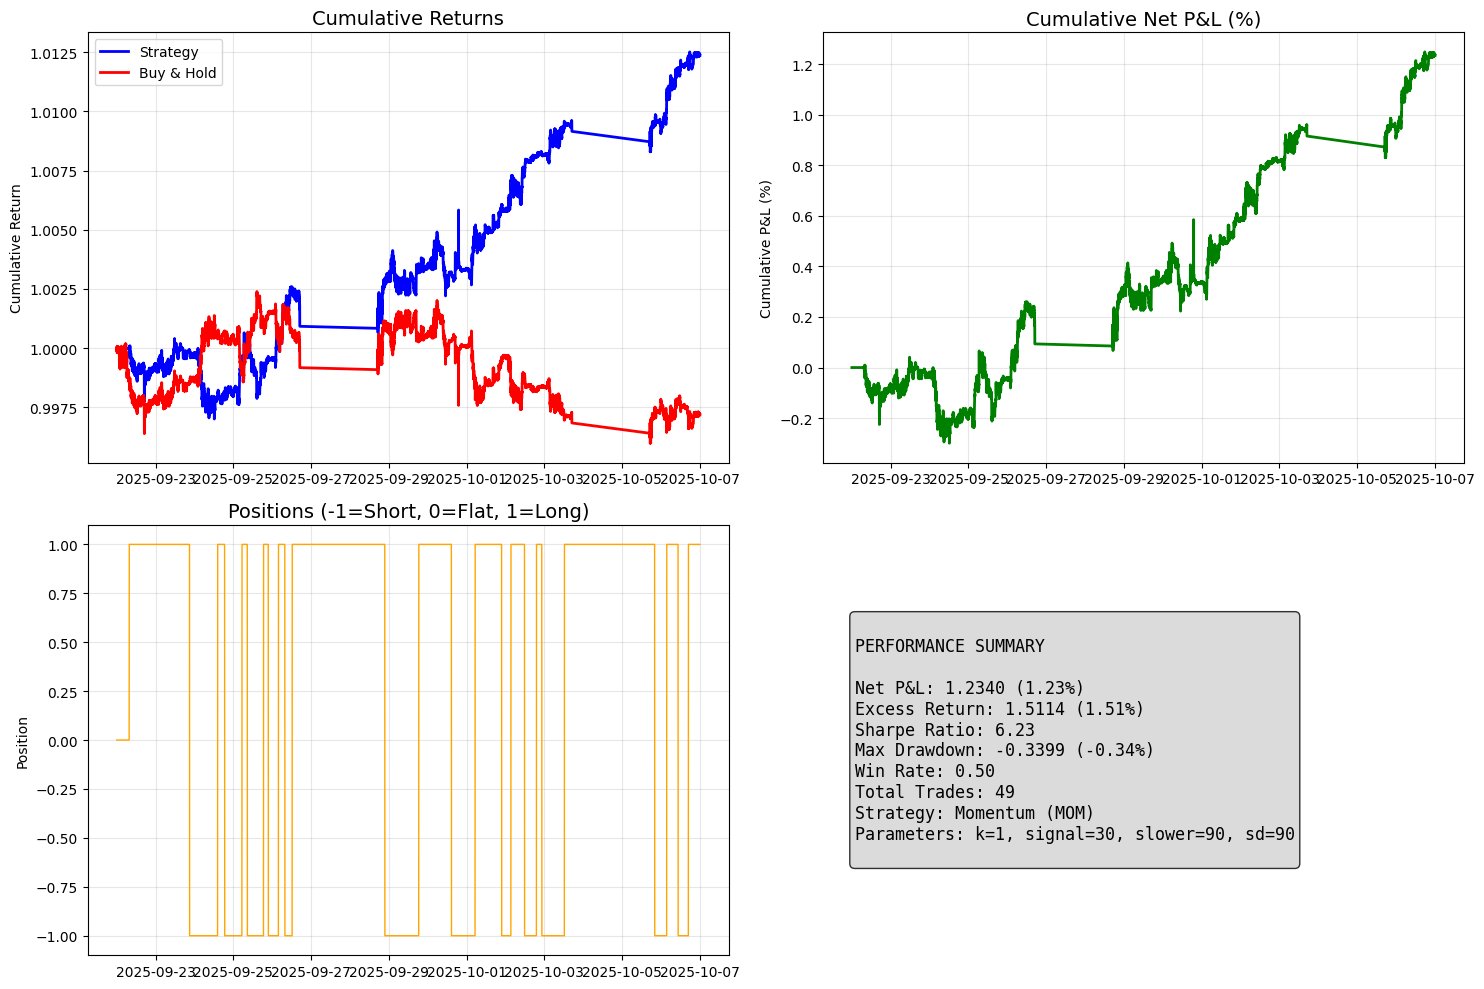

In [7]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Cumulative Returns
buy_hold_cum = (1 + test_data['Close'].pct_change().fillna(0)).cumprod()
ax1.plot(test_results['cumulative_returns'], label='Strategy', color='blue', linewidth=2)
ax1.plot(buy_hold_cum, label='Buy & Hold', color='red', linewidth=2)
ax1.set_title('Cumulative Returns', fontsize=14)
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Cumulative Net P&L
ax2.plot(test_results['net_pnl_series'].cumsum()*100, color='green', linewidth=2)
ax2.set_title('Cumulative Net P&L (%)', fontsize=14)
ax2.set_ylabel('Cumulative P&L (%)')
ax2.grid(True, alpha=0.3)

# 3. Trading Positions
ax3.plot(test_results['positions'], color='orange', linewidth=1)
ax3.set_title('Positions (-1=Short, 0=Flat, 1=Long)', fontsize=14)
ax3.set_ylabel('Position')
ax3.grid(True, alpha=0.3)

# 4. Performance Summary
ax4.axis('off')
summary_text = f"""
PERFORMANCE SUMMARY

Net P&L: {test_results['net_pnl']*100:.4f} ({test_results['net_pnl']*100:.2f}%)
Excess Return: {test_results['excess_return']*100:.4f} ({test_results['excess_return']*100:.2f}%)
Sharpe Ratio: {test_results['net_sr']:.2f}
Max Drawdown: {test_results['max_dd']*100:.4f} ({test_results['max_dd']*100:.2f}%)
Win Rate: {test_results['win_rate']:.2f}
Total Trades: {test_results['n_trades']:.0f}
Strategy: Momentum (MOM)
Parameters: k=1, signal=30, slower=90, sd=90
"""
ax4.text(0.05, 0.5, summary_text, transform=ax4.transAxes, fontsize=12, fontfamily='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()
